# **Problem Formulation**
**Objective:**

To predict the variable
N (Number of Taps) at London Underground stations using machine learning models, with a specific focus on the XGBoost Regressor, and to evaluate the performance of these models for time-series forecasting.


**Background:**

There are a number of factors that affect the volume of taps or exits from each station in London Underground's complex transit system.Understanding these patterns is crucial for optimizing station management and public transportation planning.  To make a complete view of the system, this data set is composed of several aspects that include lockdown periods, station attributes and time series.

## **Dataset:**

The dataset, derived from Transport for London's Oyster and Contactless ticketing databases, is a detailed record of tube station interactions. It records daily arrivals and exits at each tube station in 15-minute intervals from January 1, 2020 through April 30, 2021. It tracks the commencement and duration of national and regional lockdowns, as well as mandatory closures of non-essential retail, pubs/restaurants, and schools.The dataset provides a detailed overview of numerous attributes, from everyday activities and lockdown regulations to information about train terminals.

### **MACHINE LEARNING PIPELINE**
Data Preprocessing: Handling missing values, encode categorical variables, and perform feature scaling.

Feature Engineering: Creating lag features for 7 days, 14-days, 21 days.

Model Selection: Using XGBoost Regressor as the primary model, and compare its performance with other machine learning models like Random Forest, Linear Regression, and SVM.

Training and Validation: Splitting the dataset into training, validation, and test sets considering the time-series nature of the data. Use metrics like RMSE, MAE, and R-squared for evaluation.

Hyperparameter Tuning: Optimize model parameters using techniques like Random Search.

Evaluation: Assess model performance on the test set and compare the results across different models.

In [1]:
import pandas as pd
import pickle
import json
import numpy as np
from math import ceil
import pickle
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import r2_score
import os
from collections import Counter
import string
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import datetime

#### **Features Description:**

1.   <small>
CALENDARDATE: A character field representing the date of the event, formatted as '%d/%m/%Y'.
</small>
2.   <small>DOW: A character field indicating the Day of the Week.</small>

1.  <small> NLC: An integer field for the National Location Code, with values ranging from 500 to 6960.
</small>

1.   <small>SUBSYSTEM: A character field identifying the subsystem of rail taps received, set to 'LU' for London Underground.</small>

1.    <small>HOUR: A numeric field denoting the quarter-hour of the day, expressed as a decimal (e.g., 9.25 represents the period from 0915 to 0930 hrs)</small>

1.    <small>ENTRYEXIT: A character field indicating the direction of travel through the gateline, either 'ENTRY' for in or 'EXIT' for out.</small>
2.    <small>N: An integer field representing the number of taps during the 15-minute period.</small>


2.    <small>LOCKDOWN_NATIONAL and LOCKDOWN_REGIONAL: Indicate the status of national and regional lockdowns, respectively.</small>


2.    <small>SHOPS_CLOSED, PUBS_CLOSED, and SCHOOLS_CLOSED: Represent the closure status of various public establishments.</small>

2.    <small>NLC: An integer field indicating the National Location Code for each station.</small>

1.    <small>STATIONNAME: A character field providing the name of the station.</small>

1.    <small>MODE: A character field set to 'LU,' indicating the dataset is specific to the London Underground.</small>

1.     <small>BOROUGH: A character field specifying the borough, typically within the Greater London Area, where the station is located.</small>
2.    <small>STATIONTYPE: A character field classifying stations into various types like Shopping, City, Termini, and Inner/Outer Suburb.</small>

2.     <small>NAPTAN: A character field used as an alternative reference for the station, often used in TfL's Journey Planner API.</small>

2.     <small>QHR: A numeric field that represents the specific fifteen-minute interval of interest. This column sometimes aligns with the "HOUR" field in other related datasets.</small>

1. <small>PERIOD: A character field that identifies which three-hour block the given QHR falls into, with considerations for AM and PM peak periods, particularly valid on weekdays.</small>
2.  <small>The dataset enriches National Location Codes (NLC) with spatial and fare zone information for tube stations. It includes X and Y coordinates in a specialized system, a three-letter station code, fare zone, and geographical latitude and longitude.</small>


# Data Preprocessing
1.  **Handling Missing Values**:All the NaN values extracted after adding lag features dataset are replaced with zeros.
2.   **Mapping Categorical to Numerical:**Days of the week ('DOW') and entry/exit status ('ENTRYEXIT') are mapped to numerical values using label encoding for easier processing by machine learning algorithms.

1. **Date Transformation:** The 'CALENDARDATE' is converted to a datetime format.

### **Feature Engineering:**
The code is designed to enhance a time-series dataset about the London Underground by adding "lagged" features. These features capture historical data points to help make better future predictions. Here's the breakdown:

**Sorting:** The data is sorted by date, station name, National Location Code (NLC), hour, and entry/exit status. This ensures that the data is in the right order for creating lagged features.

**Lagged Features:** A new column is added for each of three specified time lags—7, 14, and 21 time units ago. These lagged features represent the number of taps (N) at the station at those previous times.

**Grouping**: The lagged features are created within groups that share the same station name, NLC, hour, and entry/exit status. This means the lagged data is specific to each unique combination of these variables.

**Time Units:** The lags of 7, 14, and 21 could represent days, hours, or any other time unit, depending on the context. They are chosen to capture weekly patterns in the data.

By adding these lagged features, the dataset gains historical context, which can improve the performance of time-series forecasting models like XGBoost Regressor.

**Date Features**: New features like 'Year', 'Month', 'Day', and 'Quarter' are created based on the 'CALENDARDATE' to capture any seasonal or time-based patterns.A binary feature 'Is_Weekend' is created to indicate whether a day is a weekend.

**One-Hot Encoding:** Categorical variables like 'STATIONTYPE', and 'LOCKDOWN_REGIONAL' are one-hot encoded.

**Mean encoding:** Station name feature is mean encoded. In mean encoding, each unique value of the categorical variable ("stationname" in this case) is replaced with the mean of the target variable ("N") corresponding to that category.

### **Modelling**

**Data Splitting:**


1.   **Datetime Conversion:** The first column of the loaded data, assumed to be timestamps, is converted to NumPy datetime objects.


**Feature and Target Separation:**
For each of the train, validation, and test sets, the following operations are performed:


1.   **Drop Date Column**: The date column (the first column) is removed.

1.   **Extract Target Variable:**The target variable
N (the third column) is separated and stored in y_train, y_valid, and y_test.
2.   **Feature Matrix:**The remaining columns serve as the feature matrix and are stored in X_train, X_valid, and X_test.

**Model Initialization:** An XGBoost Regressor model is initialized with the objective function set to 'reg:squarederror', which means it minimizes the squared error between the predicted and actual values.
2.  **Train-Validation-Test Split:**

TimeSeriesSplit: A TimeSeriesSplit object is initialized with 6 splits, meaning the data will be broken down into 6 training and test sets in a rolling-window fashion.

Metrics Initialization: Lists are created to store the Root Mean Squared Error (RMSE),
R
2
 , and Mean Absolute Error (MAE) for each fold.

**Hyper parameter tuning:**

**Rolling-Window Cross-Validation Loop:**

**Data Splitting:** In each iteration, the training and test sets are defined based on the indices provided by TimeSeriesSplit.

**Model Training:** The XGBoost model is trained on the training set for each fold.

**Prediction:** The model's predictions for the test set are calculated.


**Evaluation Metric:**

1.    **RMSE:** The Root Mean Squared Error (RMSE) is calculated between the actual validation target values y_valid and the predicted values y_valid_pred. RMSE is a common metric for evaluating the accuracy of regression models.
2.  **R 2:** The coefficient of determination R^2 is also calculated for the validation set to evaluate how well the variance in the target variable is explained by the model.

1.   **Evaluation:** RMSE,
R
2
 , and MAE are computed for the test set in each fold and stored.
2.   **Average Metrics:** After all folds are evaluated, the average RMSE,
2
R
2
 , and MAE across all folds are calculated

In [2]:
merge_data= pd.read_csv('./tfl_merge_cpldata.csv', usecols=['CALENDARDATE','DOW','ENTRYEXIT','N','ZONE','LOCKDOWN_REGIONAL','SHOPS_CLOSED','PUBS_CLOSED','SCHOOLS_CLOSED','STATIONTYPE','HOUR','STATIONNAME','NLC'])

In [3]:
merge_data.head()

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,STATIONTYPE
0,2020-02-02,SUN,501,6.75,Entry,10,1.0,0,0,0,0,Barbican,City
1,2020-02-02,SUN,501,6.75,Exit,17,1.0,0,0,0,0,Barbican,City
2,2020-02-02,SUN,501,7.00,Entry,16,1.0,0,0,0,0,Barbican,City
3,2020-02-02,SUN,501,7.00,Exit,12,1.0,0,0,0,0,Barbican,City
4,2020-02-02,SUN,501,7.25,Entry,13,1.0,0,0,0,0,Barbican,City


In [4]:
merge_data.isnull().any()

CALENDARDATE         False
DOW                  False
NLC                  False
HOUR                 False
ENTRYEXIT            False
N                    False
ZONE                 False
LOCKDOWN_REGIONAL    False
SHOPS_CLOSED         False
PUBS_CLOSED          False
SCHOOLS_CLOSED       False
STATIONNAME          False
STATIONTYPE          False
dtype: bool

In [5]:
data=merge_data.copy()

### **Data Preprocessing**

In [6]:
def perform_categorical_mapping(data, column_name, mapping_dict):
    data[column_name] = data[column_name].replace(mapping_dict)
    return data

# Mapping for day of week (DOW) feature
dow_mapping = {'MON': 1, 'TUE': 2, 'WED': 3, 'THU': 4, 'FRI': 5, 'SAT': 6, 'SUN': 7}
data = perform_categorical_mapping(data, 'DOW', dow_mapping)

# Mapping for ENTRYEXIT feature
entry_exit_mapping = {'Entry': 0, 'Exit': 1}
data = perform_categorical_mapping(data, 'ENTRYEXIT', entry_exit_mapping)

In [7]:
def extract_date_features(data, date_column_name):
    data[date_column_name] = pd.to_datetime(data[date_column_name])
    data['Year'] = data[date_column_name].dt.year.replace({2020: 0, 2021: 1}).astype('int8')
    data['Month'] = data[date_column_name].dt.month.astype('int8')
    data['Day'] = data[date_column_name].dt.day.astype('int8')
    data['Quarter'] = data[date_column_name].dt.quarter.astype('int8')
    data['Is_Weekend'] = data['DOW'].apply(lambda x: 1 if x in [6, 7] else 0).astype('int8')
    data['week_of_month'] = (data[date_column_name].dt.day + data[date_column_name].dt.dayofweek) // 7 + 1
    
    categorical_columns = ['Month', 'Day', 'Quarter', 'Is_Weekend', 'Year', 'ENTRYEXIT', 'week_of_month', 'SHOPS_CLOSED', 'PUBS_CLOSED', 'SCHOOLS_CLOSED', 'DOW']
    data[categorical_columns] = data[categorical_columns].astype('int8')
    
    return data

data = extract_date_features(data, 'CALENDARDATE')

### **Feature Engineering:**

In [75]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,LOCKDOWN_REGIONAL,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,STATIONNAME,STATIONTYPE,Year,Month,Day,Quarter,Is_Weekend,week_of_month
0,2020-02-02,7,501,6.75,0,10,1.0,0,0,0,0,Barbican,City,0,2,2,1,1,2
1,2020-02-02,7,501,6.75,1,17,1.0,0,0,0,0,Barbican,City,0,2,2,1,1,2


In [8]:
def one_hot_encode_and_convert_to_int8(data, categorical_columns):
     
    # Convert LOCKDOWN_REGIONAL to string before one-hot encoding
    data['LOCKDOWN_REGIONAL'] = data['LOCKDOWN_REGIONAL'].astype(str)
    
    data = pd.get_dummies(data, columns=categorical_columns, dtype='int8')
    return data

# Assuming 'data' is your DataFrame
categorical_columns = ['STATIONTYPE', 'LOCKDOWN_REGIONAL']
data = one_hot_encode_and_convert_to_int8(data, categorical_columns)

In [9]:
def create_lag_features(data, lag_features, lags):
    for feature in lag_features:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            data[lag_col_name] = data.groupby(['STATIONNAME', 'NLC', 'HOUR', 'ENTRYEXIT'])[feature].shift(lag)
    return data

# Assuming 'data' is your DataFrame
lag_features = ['N']
lags = [7, 14, 21]

data = data.sort_values(['CALENDARDATE', 'STATIONNAME', 'NLC', 'HOUR', 'ENTRYEXIT'])
data = create_lag_features(data, lag_features, lags)

In [10]:
data.isnull().any()

CALENDARDATE                False
DOW                         False
NLC                         False
HOUR                        False
ENTRYEXIT                   False
N                           False
ZONE                        False
SHOPS_CLOSED                False
PUBS_CLOSED                 False
SCHOOLS_CLOSED              False
STATIONNAME                 False
Year                        False
Month                       False
Day                         False
Quarter                     False
Is_Weekend                  False
week_of_month               False
STATIONTYPE_Airport         False
STATIONTYPE_City            False
STATIONTYPE_Inner Suburb    False
STATIONTYPE_Outer Suburb    False
STATIONTYPE_Shopping        False
STATIONTYPE_Terminus        False
STATIONTYPE_Tourist         False
LOCKDOWN_REGIONAL_0         False
LOCKDOWN_REGIONAL_1         False
LOCKDOWN_REGIONAL_Tier2     False
LOCKDOWN_REGIONAL_Tier3     False
LOCKDOWN_REGIONAL_Tier4     False
N_lag7        

In [11]:
data.fillna(0, inplace=True)

In [12]:
def perform_mean_encoding_and_save(data, target_col, value_col, json_filename):
    mean_encoding_map = data.groupby(target_col)[value_col].transform('mean').astype(int)
    data[target_col + '_mean_encoded'] = mean_encoding_map
    station_mean_encoded_dict = dict(zip(data[target_col], mean_encoding_map))
    
    with open(json_filename, 'w') as json_file:
        json.dump(station_mean_encoded_dict, json_file)
    
    data.drop(columns=[target_col], inplace=True)
    return data

data = perform_mean_encoding_and_save(data, 'STATIONNAME', 'N', 'station_mean_encoded.json')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254658 entries, 142 to 17251829
Data columns (total 32 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   CALENDARDATE              datetime64[ns]
 1   DOW                       int8          
 2   NLC                       int64         
 3   HOUR                      float64       
 4   ENTRYEXIT                 int8          
 5   N                         int64         
 6   ZONE                      float64       
 7   SHOPS_CLOSED              int8          
 8   PUBS_CLOSED               int8          
 9   SCHOOLS_CLOSED            int8          
 10  Year                      int8          
 11  Month                     int8          
 12  Day                       int8          
 13  Quarter                   int8          
 14  Is_Weekend                int8          
 15  week_of_month             int8          
 16  STATIONTYPE_Airport       int8          
 17  STAT

In [15]:
data.head(2)

,CALENDARDATE,DOW,NLC,HOUR,ENTRYEXIT,N,ZONE,SHOPS_CLOSED,PUBS_CLOSED,SCHOOLS_CLOSED,...,STATIONTYPE_Tourist,LOCKDOWN_REGIONAL_0,LOCKDOWN_REGIONAL_1,LOCKDOWN_REGIONAL_Tier2,LOCKDOWN_REGIONAL_Tier3,LOCKDOWN_REGIONAL_Tier4,N_lag7,N_lag14,N_lag21,STATIONNAME_mean_encoded
142,2020-02-02,7,502,6.25,0,1,1.0,0,0,0,...,0,1,0,0,0,0,0.0,0.0,0.0,38
143,2020-02-02,7,502,6.75,0,15,1.0,0,0,0,...,0,1,0,0,0,0,0.0,0.0,0.0,38


# Training Xgboost

1. converting the entire data to numpy array for efficient memory utilization in training.
2. considering dates less than '2021-02-28' as a training dataset 
3. deleting the calende date and the N value from the training data and consider N as the target variable.
4. considering data above 2021-02-28' as test data.

In [30]:
# Convert the DataFrame to a NumPy array
numpy_array = data.values

# Save the NumPy array to a file
file_path = "data.npy"
np.save(file_path, numpy_array)

In [3]:
# Specify the path to your .npy file
file_path = "./data.npy"

# Load the NumPy array from the file
loaded_data = np.load(file_path, allow_pickle=True)

In [35]:
datetime_array = np.array([pd.Timestamp(ts).to_numpy() for ts in loaded_data[:, 0]])
train_mask = (datetime_array <= np.datetime64('2021-02-28'))
train_data = loaded_data[train_mask]
# after 2021-02-28 obtained into test data 
test_mask = (datetime_array > np.datetime64('2021-02-28'))
test_data = loaded_data[test_mask]

array([[Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 0, ..., 1, 1, 1],
       [Timestamp('2020-02-02 00:00:00'), 7, 1, ..., 1, 1, 1],
       ...,
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 0, ..., 1, 1, 4],
       [Timestamp('2021-02-28 00:00:00'), 7, 1, ..., 1, 1, 4]],
      dtype=object)

In [36]:
# Save the NumPy array to a file
file_path = "train.npy"
np.save(file_path, train_data)

In [16]:
file_path = "./train.npy"
# Load the NumPy array from the file
train_data = np.load(file_path, allow_pickle=True)

In [33]:
# Save the NumPy array to a file
file_path = "test.npy"
np.save(file_path, test_data)

In [26]:
# Specify the path to your .npy file
file_path = "./test.npy"

# Load the NumPy array from the file
test_data = np.load(file_path, allow_pickle=True)

In [39]:
# Dropping the 'calenderdate' column to get the feature matrix
X = np.delete(train_data,0 , axis=1)
# Extracting the target variable 'N'
y = X[:, 2]
# Dropping the 'N' column to get the feature matrix
X = np.delete(X,2 , axis=1)
X

array([[7, 0, 1.0, ..., 1, 1, 1],
       [7, 0, 1.0, ..., 1, 1, 1],
       [7, 1, 1.0, ..., 1, 1, 1],
       ...,
       [7, 1, 4.0, ..., 1, 1, 4],
       [7, 0, 4.0, ..., 1, 1, 4],
       [7, 1, 4.0, ..., 1, 1, 4]], dtype=object)

In [27]:
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(test_data,0 , axis=1)
# Extracting the target variable 'N'
y_test = X_test[:, 2]
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(X_test,2 , axis=1)
X_test

array([[1, 0, 3.0, ..., 1, 0, 1],
       [1, 0, 3.0, ..., 1, 0, 1],
       [1, 1, 3.0, ..., 1, 0, 1],
       ...,
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5]], dtype=object)

# Training & validating Model using XGBoost

In [22]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Training the XGBoost model
xgboostmodel = xgb.XGBRegressor(objective ='reg:squarederror')

# Initialize TimeSeriesSplit
# Number of splits: 5
# Training window size: 20 observations
# Test window size: 5 observations (this is the default)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RMSE list to store RMSE values for each fold
rmse_list = []
r2_list = []
mae_list = []
# Initialize lists to store actual and predicted values across all folds
all_actual = []
all_predicted = []
# Counter for fold number
fold=0
# Perform Rolling-Window Cross-Validation
for train_index, test_index in tscv.split(X):

    # Get training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index],y[test_index]

    # Train the model on the training data
    xgboostmodel.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = xgboostmodel.predict(X_test)

    # Store actual and predicted values for this fold
    all_actual.extend(y_test)
    all_predicted.extend(y_pred)

    # Calculate RMSE (Root Mean Squared Error) for the current fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)
    # Calculate R2 (R-squared) for the current fold
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)
    # Calculate MAE for the current fold
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

    print(f"Evaluation for fold {fold}")
    print(f"MAE for the current fold: {mae}")
    print(f"RMSE for the current fold: {rmse}")
    print(f"R2 for the current fold: {r2}")
    fold+=1
# Calculate average RMSE and R2 across all folds
average_rmse = np.mean(rmse_list)
print(f"Average RMSE: {average_rmse}")
average_r2 = np.mean(r2_list)
print(f"Average R2: {average_r2}")
average_mae = np.mean(mae_list)
print(f"Average MAE: {average_mae}")

Evaluation for fold 0
MAE for the current fold: 11.164398063751092
RMSE for the current fold: 21.199431588295248
R2 for the current fold: 0.2748280479165073
Evaluation for fold 1
MAE for the current fold: 10.536303725976616
RMSE for the current fold: 19.74868075456671
R2 for the current fold: 0.9035657244950085
Evaluation for fold 2
MAE for the current fold: 12.322803828176962
RMSE for the current fold: 25.85996790541927
R2 for the current fold: 0.9186835912070108
Evaluation for fold 3
MAE for the current fold: 16.627062911723016
RMSE for the current fold: 36.25006865853165
R2 for the current fold: 0.7905393338335287
Evaluation for fold 4
MAE for the current fold: 18.354685025210095
RMSE for the current fold: 33.293049953147566
R2 for the current fold: 0.37364309290464603
Average RMSE: 27.270239771992088
Average R2: 0.6522519580713404
Average MAE: 13.801050710967559


In [ ]:
# Create the plot
plt.figure(figsize=(7, 5))
plt.scatter(all_actual, all_predicted, c='blue')
plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], '--', c='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# plt.title('Comparison of Actual and Predicted Values Across Folds in Validation Data for an XGBoost Model ')
plt.savefig('./Actual vs Predicted Values using the Validation Model using XGboost.png',  bbox_inches='tight',dpi=300)
plt.show()

### Dump xgboost model into local system

In [24]:
import pickle

# Save to file
with open('xgboostmodel.pkl', 'wb') as model_file:
    pickle.dump(xgboostmodel, model_file)

In [25]:
# Load the model from the .pkl file
with open('./xgboostmodel.pkl', 'rb') as file:
    xgboostmodel = pickle.load(file)

# Testing the XGboost Model

In [54]:
# Making predictions
y_test_pred = xgboostmodel.predict(X_test)

# Calculating the RMSE
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# Calculate R^2 for validation and test sets
r2_test_xgboost = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse_test,r2_test_xgboost,mae

(37.06550661769672, 0.7209056479106104, 18.639794148601943)

In [29]:
# Get feature importances
feature_importances = xgboostmodel.feature_importances_
feature_importances

array([0.01726008, 0.02744332, 0.01429235, 0.01317107, 0.00567941,
       0.1608364 , 0.01099765, 0.03440429, 0.43876567, 0.01146873,
       0.00676708, 0.05350577, 0.        , 0.05751482, 0.01011821,
       0.00498806, 0.01464725, 0.01052828, 0.0033943 , 0.00642849,
       0.00602461, 0.        , 0.01035206, 0.01639116, 0.0269664 ,
       0.        , 0.01756423, 0.01180334, 0.        , 0.        ,
       0.00868687], dtype=float32)

In [41]:
# Updated feature names to align with feature_importances
feature_names = [
    "CALENDARDATE",
    "NLC",
    "HOUR",
    "ENTRYEXIT",
    "N",
    "ZONE",
    "SHOPS_CLOSED",
    "PUBS_CLOSED",
    "SCHOOLS_CLOSED",
    "Year",
    "Month",
    "Day",
    "Quarter",
    "Is_Weekend",
    "week_of_month",
    "STATIONTYPE_Airport",
    "STATIONTYPE_City",
    "STATIONTYPE_Inner Suburb",
    "STATIONTYPE_Outer Suburb",
    "STATIONTYPE_Shopping",
    "STATIONTYPE_Terminus",
    "STATIONTYPE_Tourist",
    "LOCKDOWN_REGIONAL_0",
    "LOCKDOWN_REGIONAL_1",
    "LOCKDOWN_REGIONAL_Tier2",
    "LOCKDOWN_REGIONAL_Tier3",
    "LOCKDOWN_REGIONAL_Tier4",
    "N_lag7",
    "N_lag14",
    "N_lag21",
    "STATIONNAME_mean_encoded",
]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
8,SCHOOLS_CLOSED,0.438766
5,ZONE,0.160836
13,Is_Weekend,0.057515
11,Day,0.053506
7,PUBS_CLOSED,0.034404
1,NLC,0.027443
24,LOCKDOWN_REGIONAL_Tier2,0.026966
26,LOCKDOWN_REGIONAL_Tier4,0.017564
0,CALENDARDATE,0.017260
23,LOCKDOWN_REGIONAL_1,0.016391


# Actual values w.r.t True values on the test set using XGboost Model

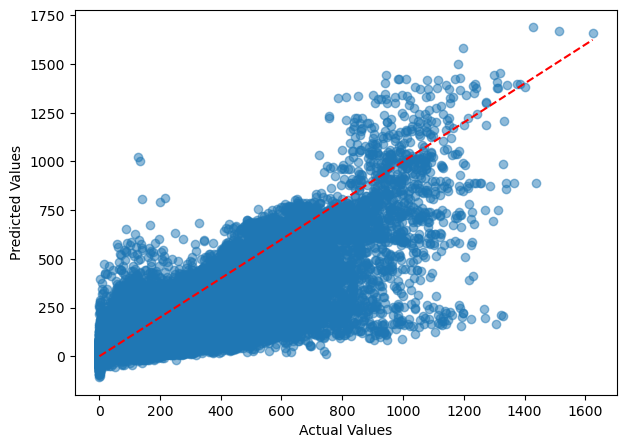

In [55]:
# Plotting the actual vs predicted values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# plt.title('Actual vs Predicted Values for Test Set using the XGBoost Model')
plt.savefig('./Actual vs Predicted Values for Test Set using the XGBoost Model.png',  bbox_inches='tight',dpi=300)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', c='red')
plt.show()

In [45]:
# the first column of train_data is the timestamp column
timestamps = test_data[:, 0]

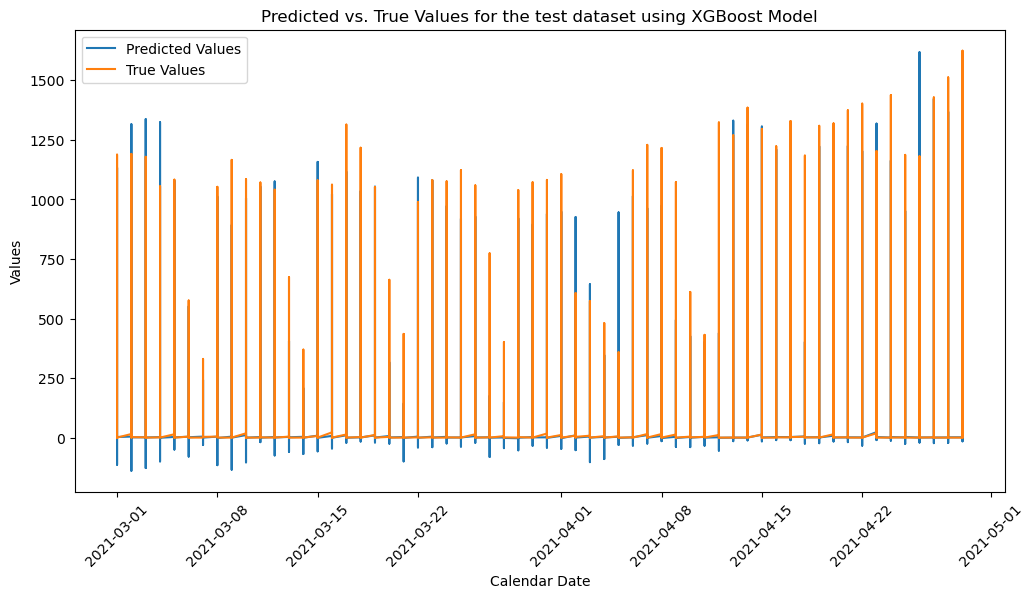

In [35]:
# Create a plot for predicted vs. true values based on CALENDARDATE
plt.figure(figsize=(12, 6))
plt.plot(timestamps, y_test_pred, label='Predicted Values')
plt.plot(timestamps, y_test, label='True Values')
plt.xlabel('Calendar Date')
plt.ylabel('Values')
plt.title('Predicted vs. True Values for the test dataset using XGBoost Model')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('./Predictionvs true labels for xgboost model2.png',  bbox_inches='tight')
plt.show()

# Random Forest Regressor Model

In [11]:
# Initialize RandomForestClassifier
model = RandomForestRegressor(criterion ='squared_error',max_depth=9)

# Training and validating the Random Forest Regressor

In [12]:
    # Initialize TimeSeriesSplit
    # Number of splits: 5
    # Training window size: 20 observations
    # Test window size: 5 observations (this is the default)
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize RMSE list to store RMSE values for each fold
    rmse_list = []
    r2_list = []
    mae_list = []
    # Initialize lists to store actual and predicted values across all folds
    all_actual = []
    all_predicted = []
    # Counter for fold number
    fold=0
    # Perform Rolling-Window Cross-Validation
    for train_index, test_index in tscv.split(X):

        # Get training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index],y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Store actual and predicted values for this fold
        all_actual.extend(y_test)
        all_predicted.extend(y_pred)

        # Calculate RMSE (Root Mean Squared Error) for the current fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        # Calculate R2 (R-squared) for the current fold
        r2 = r2_score(y_test, y_pred)
        r2_list.append(r2)
        # Calculate MAE for the current fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_list.append(mae)

        print(f"Evaluation for fold {fold}")
        print(f"MAE for the current fold: {mae}")
        print(f"RMSE for the current fold: {rmse}")
        print(f"R2 for the current fold: {r2}")
        fold+=1
    # Calculate average RMSE and R2 across all folds
    average_rmse = np.mean(rmse_list)
    print(f"Average RMSE: {average_rmse}")
    average_r2 = np.mean(r2_list)
    print(f"Average R2: {average_r2}")
    average_mae = np.mean(mae_list)
    print(f"Average MAE: {average_mae}")

Evaluation for fold 0
MAE for the current fold: 8.155751620535277
RMSE for the current fold: 17.176404740094952
R2 for the current fold: 0.5239450387915374
Evaluation for fold 1
MAE for the current fold: 10.796182918405254
RMSE for the current fold: 21.625029767518605
R2 for the current fold: 0.8843704937097555
Evaluation for fold 2
MAE for the current fold: 12.913823529093134
RMSE for the current fold: 24.20826298844957
R2 for the current fold: 0.9287393983456633
Evaluation for fold 3
MAE for the current fold: 17.979429247393345
RMSE for the current fold: 39.97773190973256
R2 for the current fold: 0.7452459388287507
Evaluation for fold 4
MAE for the current fold: 15.996814403194582
RMSE for the current fold: 31.435729235390884
R2 for the current fold: 0.4415789447574121
Average RMSE: 26.884631728237316
Average R2: 0.7047759628866237
Average MAE: 13.168400343724318


# Actual values w.r.t predicted values on the validation set using random forest model

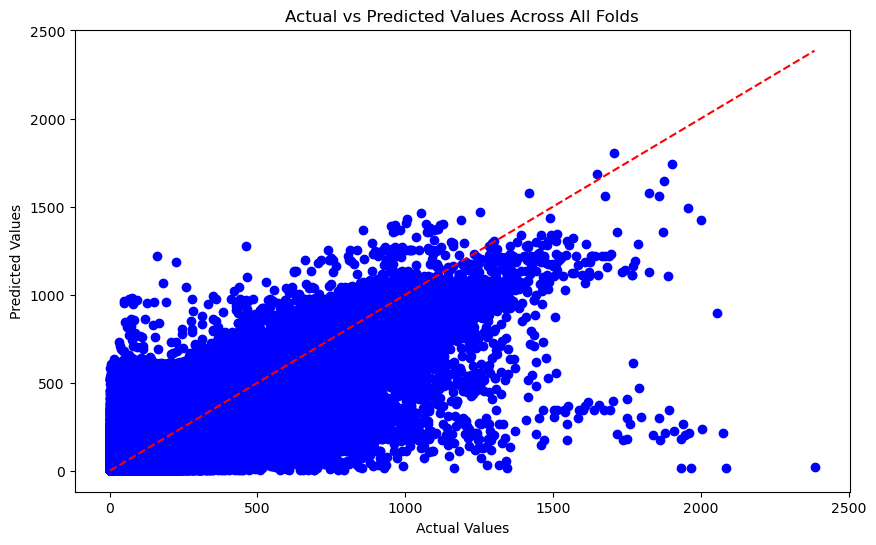

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(all_actual, all_predicted, c='blue')
plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], '--', c='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Across All Folds Random forest')
plt.show()

In [13]:
import pickle

# Save to file
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [16]:
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(test_data,0 , axis=1)
# Extracting the target variable 'N'
y_test = X_test[:, 2]
# Dropping the 'N' column to get the feature matrix
X_test = np.delete(X_test,2 , axis=1)
X_test

array([[1, 0, 3.0, ..., 1, 0, 1],
       [1, 0, 3.0, ..., 1, 0, 1],
       [1, 1, 3.0, ..., 1, 0, 1],
       ...,
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5],
       [4, 1, 4.0, ..., 2, 0, 5]], dtype=object)

In [17]:
y_test

array([1, 13, 2, ..., 3, 3, 1], dtype=object)

In [47]:
# Load the model from the .pkl file
with open('./random_forest_model.pkl', 'rb') as file:
    random_forest_model = pickle.load(file)

In [52]:
# Making predictions
y_test_pred = random_forest_model.predict(X_test)

# Calculating the RMSE
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# Calculate R^2 for validation and test sets
r2_test_xgboost = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse_test,r2_test_xgboost,mae

(40.3534598802339, 0.6691945007976683, 19.78849845080786)

# Actual values w.r.t vali values on the test set using random forest model

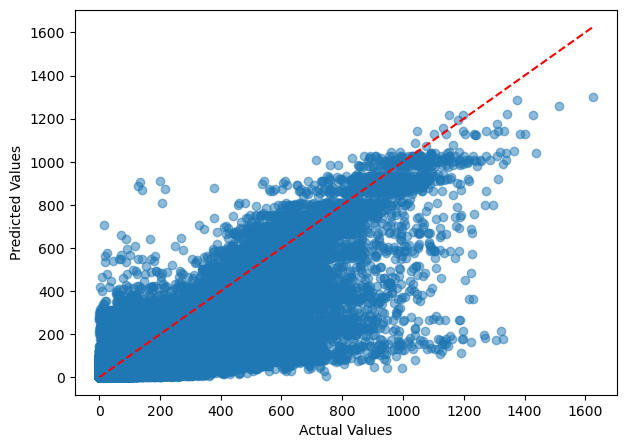

In [53]:
# Plotting the actual vs predicted values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# plt.title('Actual vs Predicted Values for Test Set using the Random forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', c='red')
plt.savefig('./Predictionvs true labels for randomforest model on test dataset.png',  bbox_inches='tight',dpi=300)
plt.show()

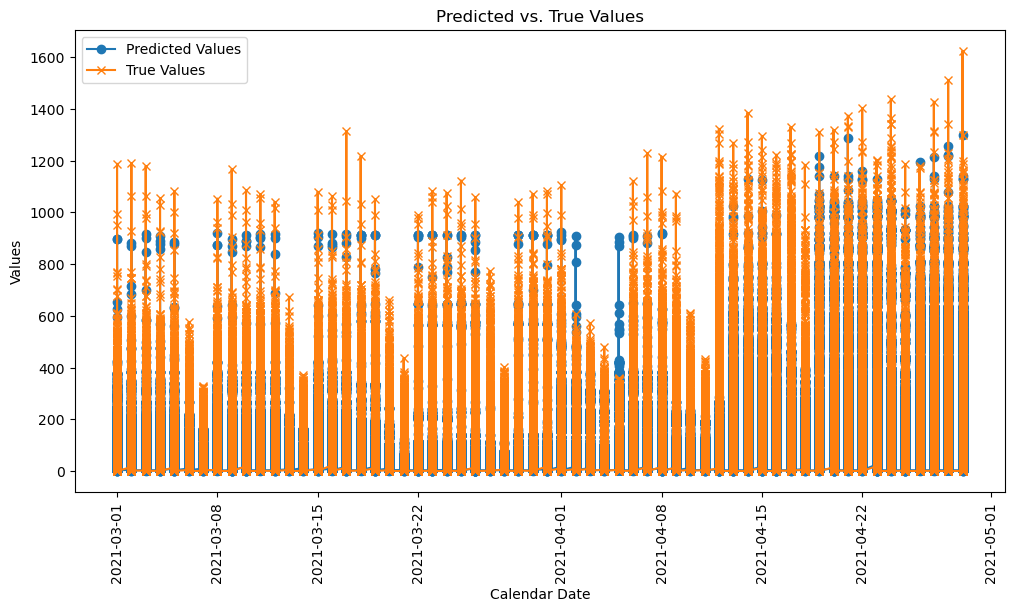

In [75]:
plt.figure(figsize=(12,6))
plt.plot(timestamps, y_test_pred, label='Predicted Values', marker='o')
plt.plot(timestamps, y_test, label='True Values', marker='x')
plt.xlabel('Calendar Date')
plt.ylabel('Values')
plt.title('Predicted vs. True Values')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('./Predictionvs true labels for Random forest model calenderdate.png',  bbox_inches='tight')
plt.show()